# レスラー方程式(ランダムなシフト付きsin外力のある状態)

レスラー方程式の外力のある場合に関して，$\sin$ 波に位相のランダムなシフトがある場合を考える．

In [10]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time


CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


mu = 0.01
A = 0.1
initial_state = [1.0, 0.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]

# 時間の設定
t_span = [0, 10000]  # 開始時刻と終了時刻
t_eval = np.linspace(t_span[0], t_span[1], 100000)  # 評価する時間点

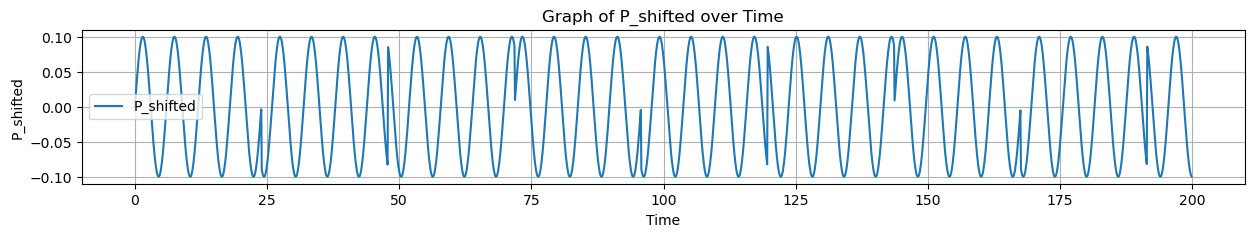

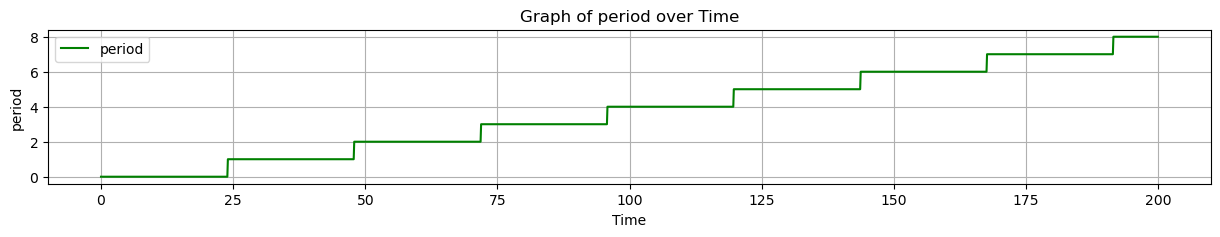

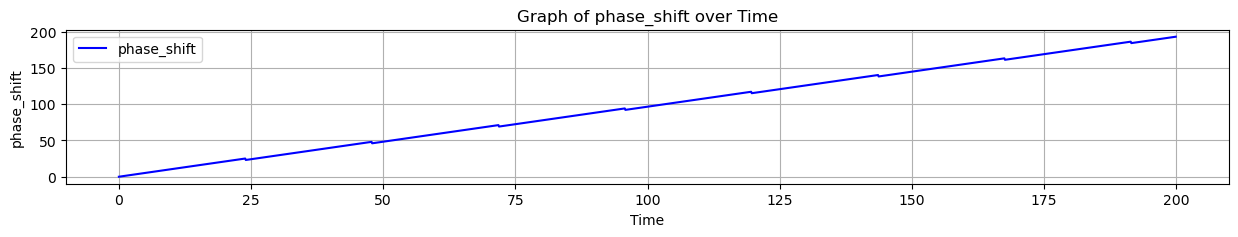

[[0.00000000e+00 1.00001000e-01 2.00002000e-01 ... 9.99980000e+03
  9.99990000e+03 1.00000000e+04]
 [0.00000000e+00 1.04808213e-02 2.08461954e-02 ... 5.54156749e-02
  6.38348354e-02 7.15508491e-02]]


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps

shift_hour = -8

sample = 2000

# P_shifted の計算
period = np.floor(1.05*t_eval / (4*2*np.pi))
phase_shift = 1.05 * t_eval + period * (shift_hour / 24) * 2 * np.pi
P_shifted = A * np.sin(phase_shift)

# P_shifted のグラフを描画
plt.figure(figsize=(15, 2))
plt.plot(t_eval[:sample], P_shifted[:sample], label='P_shifted')
plt.title('Graph of P_shifted over Time')
plt.xlabel('Time')
plt.ylabel('P_shifted')
plt.legend()
plt.grid(True)

# period のグラフを描画
plt.figure(figsize=(15, 2))
plt.plot(t_eval[:sample], period[:sample], label='period', color='green')
plt.title('Graph of period over Time')
plt.xlabel('Time')
plt.ylabel('period')
plt.legend()
plt.grid(True)

# period のグラフを描画
plt.figure(figsize=(15, 2))
plt.plot(t_eval[:sample], phase_shift[:sample], label='phase_shift', color='blue')
plt.title('Graph of phase_shift over Time')
plt.xlabel('Time')
plt.ylabel('phase_shift')
plt.legend()
plt.grid(True)

plt.show()

# t_eval と P_shifted を組み合わせて二次元配列を作成
P_shifted_combined = np.vstack((t_eval, P_shifted))

# 配列の形状を確認（オプション）
print(P_shifted_combined)


In [13]:
def find_P_shift(t_eval, t):
    idx = np.searchsorted(t_eval, t)
    if idx > 0 and (idx == len(t_eval) or np.abs(t - t_eval[idx-1]) < np.abs(t - t_eval[idx])):
        idx = idx - 1
    return idx


In [14]:
# 微分方程式の定義（P_shifted を直接使用）
def coupled_system(t, state, mu, A):
    X, Y = state
    # t_eval と一致する t のインデックスを見つける

    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + P_shifted[find_P_shift(t_eval, t)]
    
    return [dXdt, dYdt]

# 微分方程式を解く
sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, A), t_eval=t_eval)


In [15]:
import pandas as pd

# DataFrameの作成
data_frame_with_shifted_force = pd.DataFrame({
    'time': sol.t,
    'x': sol.y[0],
    'y': sol.y[1],
    'P_shifted': [P_shifted[find_P_shift(t_eval, t)] for t in sol.t]  # 位相シフトされた外力P(t)の列を追加
})


In [16]:
dir_name = f"DEMO_data"
os.makedirs(dir_name, exist_ok=True)

filename_with_force = f"{dir_name}/VDP_{shift_hour}.csv"

# CSVファイルにデータを保存
data_frame_with_shifted_force.to_csv(filename_with_force, index=False)

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded_with_force[['x', 'y', 'P_shifted']].values


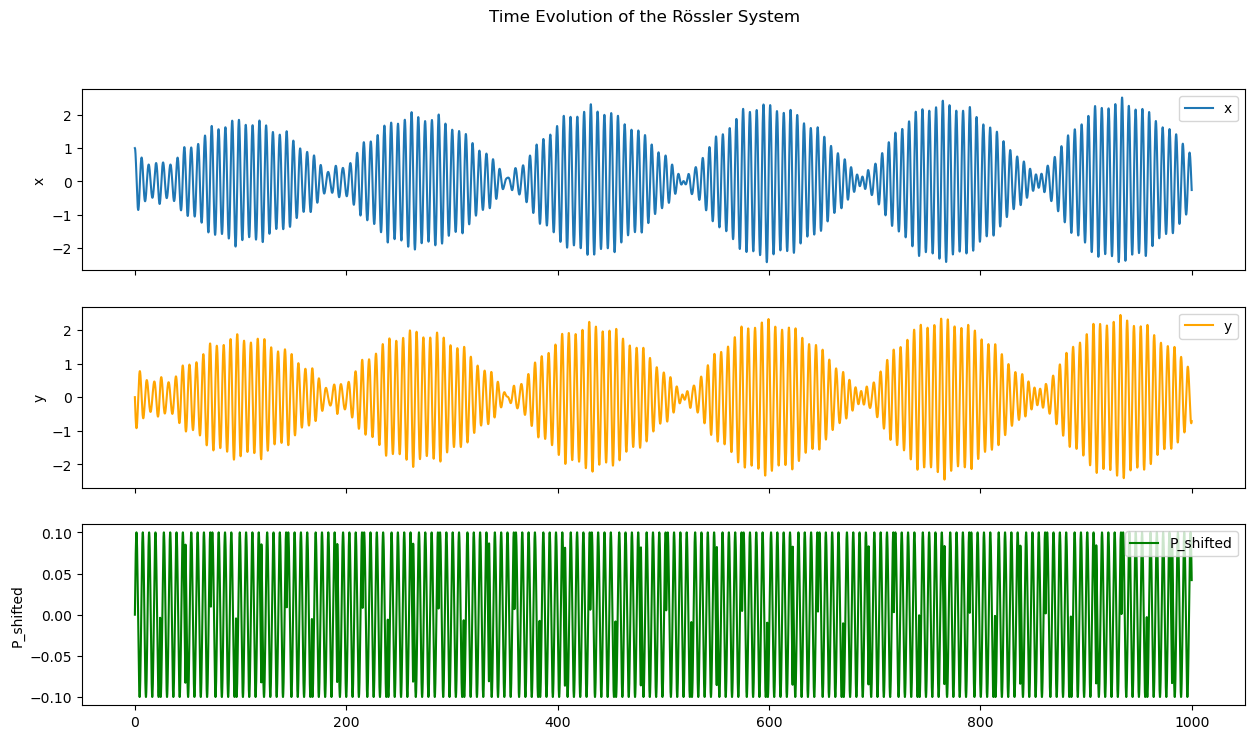

In [19]:
sample = 0
plot_length = 10000

# 時間ごとのx, y, zそれぞれのグラフ
fig, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
axs[0].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['x'][sample: sample+plot_length], label='x')
axs[0].set_ylabel('x')
axs[0].legend(loc='upper right')

axs[1].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['y'][sample: sample+plot_length], label='y', color='orange')
axs[1].set_ylabel('y')
axs[1].legend(loc='upper right')

# Plot P_shifted vs. time
axs[2].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['P_shifted'][sample: sample+plot_length], label='P_shifted', color='green')
axs[2].set_ylabel('P_shifted')
axs[2].legend(loc='upper right')

plt.suptitle('Time Evolution of the Rössler System')
plt.show()